In [1]:
import cv2
import numpy as np
from matplotlib import pyplot as plt
import pandas as pd
import os
from glob import glob
from tqdm import tqdm
from random import randint
from IPython.display import clear_output
import ast

In [2]:
train_anns = dict()
train_anns['images'] = []
train_anns['annotations'] = []
train_anns['categories'] = [{'id': 0, 'name': 'wheat'}]
iid = 0
im2id = {}
aid = 0


In [3]:
## Init constant
DATA_DIR = './data/Wheatdetection'
IMG_DIR = f"{DATA_DIR}/train"
TARGETS = ['arvalis_1', 'arvalis_2', 'arvalis_3', 'inrae_1', 'usask_1', 'rres_1', 'ethz_1']
N_PATCH = [(2, 3), (2, 2), (2, 2), (2, 2), (1, 2), (2, 3), (1, 2)]
BOX_COLOR = [0,0,255]

### Image utils function

In [4]:
def plot_img(img, size=(7,7), is_rgb=False, title=""):
    if isinstance(img, str):
        img = load_img(img)
    plt.figure(figsize=size)
    if is_rgb:
        plt.imshow(img)
    else:
        plt.imshow(img[:,:,::-1])
    plt.suptitle(title)
    plt.show()
    
def plot_imgs(imgs, cols=5, size=7, is_rgb=False, title=""):
    rows = len(imgs)//cols + 1
    fig = plt.figure(figsize=(cols*size, rows*size))
    for i, img in enumerate(imgs):
        if isinstance(img, str):
            img = load_img(img, size=300)
        fig.add_subplot(rows, cols, i+1)
        if is_rgb:
            plt.imshow(img)
        else:
            plt.imshow(img[:,:,::-1])
    plt.suptitle(title)
    plt.show()
    
def visualize_bbox(img, boxes, thickness=3, color=BOX_COLOR):
    img_copy = img.copy()
    for box in boxes:
        #if(box[0] > 900 or box[1] > 900 or box[2] > 900 or box[3] > 900):
        if(box[0]%1024==0 or box[1]%1024==0 or box[2]%1024==0 or box[3]%1024==0):
          #if(box[0]% 1024 < 50 or box[0]%1024 > 970 or box[2]% 1024 < 50 or box[2]%1024 > 970 or box[1]% 1024 < 50 or box[1]%1024 > 970 or box[3]% 1024 < 50 or box[3]%1024 > 970):
            img_copy = cv2.rectangle(
                img_copy,
                (int(box[0]), int(box[1])),
                (int(box[2]), int(box[3])),
                color, thickness)
    return img_copy

def load_img(img_id):
    cv2.imread(f"{IMG_DIR}/{img_id}.jpg")

In [5]:

df = pd.read_csv(f"{DATA_DIR}/train.csv")
df[['x1', 'y1', 'w', 'h']] = pd.DataFrame(np.stack(df['bbox'].apply(lambda x: ast.literal_eval(x)))).astype(np.float32)
df['x2'] = df['x1'] + df['w']
df['y2'] = df['y1'] + df['h']
df.head()

image_id  width  height                         bbox   source     x1  \
0  b6ab77fd7   1024    1024   [834.0, 222.0, 56.0, 36.0]  usask_1  834.0   
1  b6ab77fd7   1024    1024  [226.0, 548.0, 130.0, 58.0]  usask_1  226.0   
2  b6ab77fd7   1024    1024  [377.0, 504.0, 74.0, 160.0]  usask_1  377.0   
3  b6ab77fd7   1024    1024  [834.0, 95.0, 109.0, 107.0]  usask_1  834.0   
4  b6ab77fd7   1024    1024  [26.0, 144.0, 124.0, 117.0]  usask_1   26.0   

      y1      w      h     x2     y2  
0  222.0   56.0   36.0  890.0  258.0  
1  548.0  130.0   58.0  356.0  606.0  
2  504.0   74.0  160.0  451.0  664.0  
3   95.0  109.0  107.0  943.0  202.0  
4  144.0  124.0  117.0  150.0  261.0

In [6]:
marking = pd.read_csv(f"{DATA_DIR}/train.csv")
bboxs = np.stack(marking['bbox'].apply(lambda x: np.fromstring(x[1:-1], sep=',')))
for i, column in enumerate(['x', 'y', 'w', 'h']):
    marking[column] = bboxs[:,i]
marking.drop(columns=['bbox'], inplace=True)

import os
from datetime import datetime
import time
import random
import cv2
import pandas as pd
import numpy as np
import albumentations as A
import matplotlib.pyplot as plt
from albumentations.pytorch.transforms import ToTensorV2
from sklearn.model_selection import StratifiedKFold
from torch.utils.data import Dataset,DataLoader
from torch.utils.data.sampler import SequentialSampler, RandomSampler
from glob import glob

skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

df_folds = marking[['image_id']].copy()
df_folds.loc[:, 'bbox_count'] = 1
df_folds = df_folds.groupby('image_id').count()
df_folds.loc[:, 'source'] = marking[['image_id', 'source']].groupby('image_id').min()['source']
df_folds.loc[:, 'stratify_group'] = np.char.add(
    df_folds['source'].values.astype(str),
    df_folds['bbox_count'].apply(lambda x: f'_{x // 15}').values.astype(str)
)
df_folds.loc[:, 'fold'] = 0

print(set(df_folds.source.values))

for fold_number, (train_index, val_index) in enumerate(skf.split(X=df_folds.index, y=df_folds['stratify_group'])):
    df_folds.loc[df_folds.iloc[val_index].index, 'fold'] = fold_number
    
val_id = df_folds[df_folds['fold'] == fold_number].index.values


def combine_result_masked(patch_grid, df):
    h, w = patch_grid.shape
    total_img = np.zeros((h*1024, w*1024, 3))
    all_boxes = []
    patch_img_ids = []
    
    for r in range(h):
        for c in range(w):
            img_id = patch_grid[r, c]["img_id"]
            patch_img = cv2.imread(f"{IMG_DIR}/{img_id}.jpg")
            
            xrange = [c*1024, (c+1)*1024]
            yrange = [r*1024, (r+1)*1024]
            
            #print(img_id)
            if img_id not in val_id:
                total_img[
                    yrange[0] : yrange[1],
                    xrange[0] : xrange[1], :
                ] = patch_img
            
            boxes = df[df["image_id"] == img_id][["x1", 'y1', 'x2', 'y2']]
            boxes["x1"] += xrange[0]
            boxes["x2"] += xrange[0]
            boxes["y1"] += yrange[0]
            boxes["y2"] += yrange[0]
            all_boxes.append(boxes)
            patch_img_ids.append(img_id)
    all_boxes = pd.concat(all_boxes)
    total_img = total_img.astype(np.uint8)
    return total_img, all_boxes, patch_img_ids

{'rres_1', 'ethz_1', 'usask_1', 'arvalis_3', 'arvalis_2', 'arvalis_1', 'inrae_1'}


/home/peiyuanl/anaconda3/envs/gnn/lib/python3.7/site-packages/sklearn/model_selection/_split.py:657: Warning: The least populated class in y has only 1 members, which is too few. The minimum number of members in any class cannot be less than n_splits=5.
  % (min_groups, self.n_splits)), Warning)


## Get left, right, top, bottom edges each image 

# Note: Run this for each tar_id for several times to generate COCO

In [7]:
TAR_ID = 6
img_ids = df[df["source"] == TARGETS[TAR_ID]]["image_id"].unique()
IMG_N = len(img_ids)
print(IMG_N)

l_edges = []
r_edges = []
t_edges = []
b_edges = []

for i, img_id in enumerate(img_ids):
    img = cv2.imread(f"{IMG_DIR}/{img_id}.jpg")
    ## normalize values by dividing max values
    l_edges.append(img[:,:1,:] / img[:,:1,:].max())
    r_edges.append(img[:,-1:,:] / img[:,-1:,:].max())
    t_edges.append(img[:1,:,:] / img[:1,:,:].max())
    b_edges.append(img[-1:,:,:] / img[-1:,:,:].max())
    
l_edges = np.squeeze(np.array(l_edges))
r_edges = np.squeeze(np.array(r_edges))
t_edges = np.squeeze(np.array(t_edges))
b_edges = np.squeeze(np.array(b_edges))

747


## Compute left-right distance, top-bottom distance matrix

LR_distance[i,j]: distance between I image's left edge and J image's right edge

TB_distance[i,j]: distance between I image's top edge and J image's bottom edge

In [8]:
def distance(edge1, edge2):
    d1 = np.abs(edge1 - edge2).mean()
    d2 = np.abs(edge1[1:,:] - edge2[:-1,:]).mean()
    d3 = np.abs(edge2[1:,:] - edge1[:-1,:]).mean()
    total_distance = d1+d2+d3
    return total_distance


LR_distance = np.zeros((IMG_N, IMG_N)) + 1e3
TB_distance = np.zeros((IMG_N, IMG_N)) + 1e3

for i, left in enumerate(l_edges):
    for j, right in enumerate(r_edges):
        if i == j:
            continue
        LR_distance[i,j] = distance(left, right)
print(LR_distance.shape)


for i, top in enumerate(t_edges):
    for j, bottom in enumerate(b_edges):
        if i == j:
            continue
        TB_distance[i,j] = distance(top, bottom)
print(TB_distance.shape)

(747, 747)
(747, 747)


# Search best matches 

In [9]:
def get_best_bottom_img(top_id, TB_distance):
    index = np.argmin(TB_distance[:, top_id])
    distance = TB_distance[index, top_id]
    return index, distance

def get_best_right_img(left_id, LR_distance):
    index = np.argmin(LR_distance[:, left_id])
    distance = LR_distance[index, left_id]
    return index, distance

def get_best_right_bottom_img(top_id, left_id, TB_distance, LR_distance):
    index = np.argmin(TB_distance[:, top_id] + LR_distance[:, left_id])
    distance = (TB_distance[index, top_id] + LR_distance[index, left_id])/2
    return index, distance

def index_grid_to_info_grid(patch_grid, img_ids):
    h_grid, w_grid = patch_grid.shape
    PATCH_INFO_GRID = np.zeros(patch_grid.shape).astype(np.object)
    for row in range(h_grid):
        for col in range(w_grid):
            index = patch_grid[row, col]
            PATCH_INFO_GRID[row, col] = {
                "index": index,
                "img_id": img_ids[index]
            }
    return PATCH_INFO_GRID


## Convert index-grid to info-grid
def combine_result(patch_grid, df):
    h, w = patch_grid.shape
    total_img = np.zeros((h*1024, w*1024, 3))
    all_boxes = []
    patch_img_ids = []
    
    for r in range(h):
        for c in range(w):
            img_id = patch_grid[r, c]["img_id"]
            patch_img = cv2.imread(f"{IMG_DIR}/{img_id}.jpg")
            
            xrange = [c*1024, (c+1)*1024]
            yrange = [r*1024, (r+1)*1024]
            total_img[
                yrange[0] : yrange[1],
                xrange[0] : xrange[1], :
            ] = patch_img
            
            boxes = df[df["image_id"] == img_id][["x1", 'y1', 'x2', 'y2']]
            boxes["x1"] += xrange[0]
            boxes["x2"] += xrange[0]
            boxes["y1"] += yrange[0]
            boxes["y2"] += yrange[0]
            all_boxes.append(boxes)
            patch_img_ids.append(img_id)
    all_boxes = pd.concat(all_boxes)
    total_img = total_img.astype(np.uint8)
    return total_img, all_boxes, patch_img_ids

## Main stratery

In [10]:
print(TAR_ID)
THRESHOLDS = [0.25, 0.33, 0.25, 0.25, 0.2, 0.1, 0.25]
threshold = THRESHOLDS[TAR_ID]
ALL_PATCH_GRIDS = []

for i, img_id in enumerate(img_ids):
    PATCH_GRID = np.zeros(N_PATCH[TAR_ID]).astype(np.object)
    h_grid, w_grid = PATCH_GRID.shape 
    PATCH_GRID[0,0] = i
    all_distance = []
    
    for row in range(h_grid):
        for col in range(w_grid):
            if col == 0 and row == 0:
                continue
            if col == 0:
                top_id = int(PATCH_GRID[row-1, col])
                PATCH_GRID[row, col], distance = get_best_bottom_img(top_id, TB_distance)
            if row == 0:
                left_id = int(PATCH_GRID[row, col-1])
                PATCH_GRID[row, col], distance = get_best_right_img(left_id, LR_distance)
            if row*col > 0:
                top_id = PATCH_GRID[row-1,col]
                left_id = PATCH_GRID[row, col-1]
                PATCH_GRID[row, col], distance = get_best_right_bottom_img(
                    top_id, left_id,
                    TB_distance, LR_distance
                )
            all_distance.append(distance)

    avg_distance = np.mean(all_distance)
    if avg_distance < threshold:
        ALL_PATCH_GRIDS.append(PATCH_GRID)
        
print(len(ALL_PATCH_GRIDS))

6
370


## Save new data

Remove the comment code if you want to save data

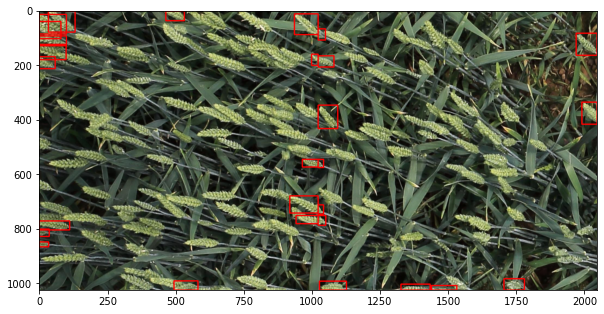

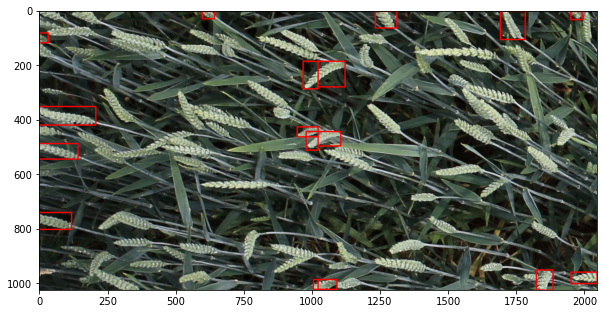

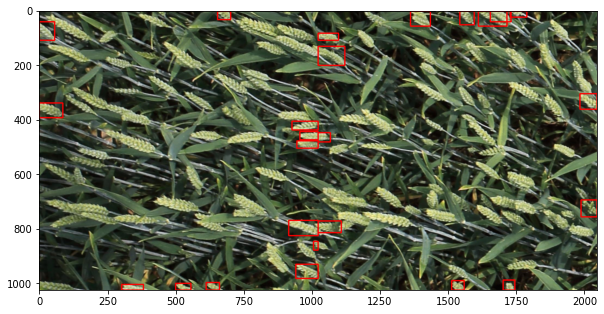

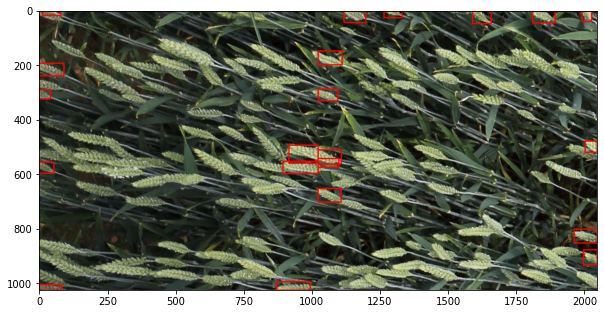

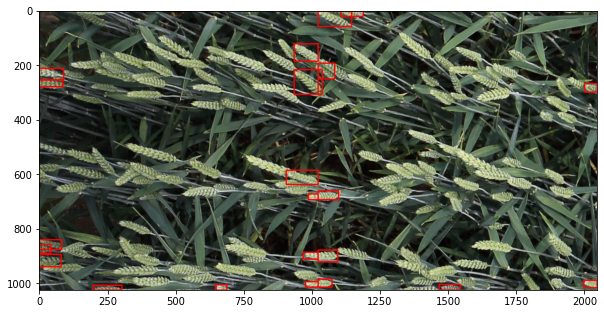

SAVE NEW DATA IN: origin_ethz_1.csv


In [11]:
all_new_data = []
source = TARGETS[TAR_ID]
new_img_dir = "origin_img_masked" 
os.makedirs(new_img_dir, exist_ok=True)

for i, patch_grid in enumerate(ALL_PATCH_GRIDS):
    patch_grid = index_grid_to_info_grid(patch_grid, img_ids)
    total_img, boxes, patch_img_ids = combine_result_masked(patch_grid, df)
    bimg = total_img.copy()
    #print(boxes)
    for box in boxes.iterrows():
        box = box[1]
        bimg = cv2.rectangle(bimg,(box.x1, box.y1),(box.x2, box.y2),(102,255,0), 3)
    new_img_ids = source + '_' + "_".join(patch_img_ids)
    boxes["image_id"] = new_img_ids
    all_new_data.append(boxes)
    cv2.imwrite(f"{new_img_dir}/{new_img_ids}.jpg", total_img)
    cv2.imwrite(f"annotated/{new_img_ids}_annotated.jpg", bimg)
    
    if i < 5:
        total_img = visualize_bbox(total_img, boxes.values)
        plot_img(total_img, size=(10,10))
        #print(new_img_ids)

all_new_data = pd.concat(all_new_data)
csv_path = f"origin_{source}.csv"
print(f"SAVE NEW DATA IN: {csv_path}")

all_new_data.to_csv(csv_path)

In [11]:
all_new_data

x1      y1      x2      y2                    image_id
55224     34.0     0.0   132.0    77.0  ethz_1_f1794c924_900d273d2
55225    150.0   799.0   264.0   865.0  ethz_1_f1794c924_900d273d2
55226    453.0    47.0   543.0   124.0  ethz_1_f1794c924_900d273d2
55227    154.0   645.0   258.0   692.0  ethz_1_f1794c924_900d273d2
55228    648.0   697.0   760.0   760.0  ethz_1_f1794c924_900d273d2
...        ...     ...     ...     ...                         ...
106708  1331.0   855.0  1375.0   912.0  ethz_1_49fbdf27c_85189f1bf
106709  1338.0   917.0  1390.0   987.0  ethz_1_49fbdf27c_85189f1bf
106710  1367.0   890.0  1421.0   971.0  ethz_1_49fbdf27c_85189f1bf
106711  1379.0   965.0  1452.0  1024.0  ethz_1_49fbdf27c_85189f1bf
106712  1330.0  1005.0  1415.0  1024.0  ethz_1_49fbdf27c_85189f1bf

[51037 rows x 5 columns]

In [12]:
for im in tqdm(list(set(all_new_data.image_id.values))):
    image = cv2.imread(f"{new_img_dir}/{new_img_ids}.jpg")
    height, width, _ = image.shape
    image = {
        'file_name': f"{im}.jpg",
        'height': height,
        'width': width,
        'id': iid
            }
    train_anns['images'].append(image)
    im2id[im] = iid
    iid+=1
    #print(image.shape)
    #break

area = lambda x: (int(x[3])-int(x[1]))*(int(x[2])-int(x[0]))
for _, row in tqdm(all_new_data.iterrows()):
    #print(eval(row.bbox))
    bbox = [row.x1, row.y1, row.x2, row.y2]
    x = bbox
    ann = {
        'segmentation': [[x[0],x[1], #(x1, y1)
                          x[2],x[1], #(x2, y1)
                          x[2],x[3], #(x2, y2)
                          x[0],x[3]]], #(x1, y1)
        'area': area(bbox),
        'iscrowd': 0,
        'image_id': im2id[row.image_id],
        'bbox': bbox,
        'category_id': 0,
        'id': aid
    }
    aid += 1
    train_anns['annotations'].append(ann)
    #break

100%|██████████| 370/370 [00:07<00:00, 48.62it/s]
51037it [00:06, 8094.15it/s]


In [13]:
#train_anns

In [14]:
import json
"""
ANN = '/home/peiyuanl/kaggle/wheat_det/'
# Serializing json  
json_object = json.dumps(train_anns, indent = 4) 

with open(ANN+"full_annotations.json", "w") as outfile: 
    outfile.write(json_object) 
"""

'\nANN = \'/home/peiyuanl/kaggle/wheat_det/\'\n# Serializing json  \njson_object = json.dumps(train_anns, indent = 4) \n\nwith open(ANN+"full_annotations.json", "w") as outfile: \n    outfile.write(json_object) \n'

In [15]:
df = all_new_data

In [16]:
ut = 1
lt = 1023
a = df.loc[df['x1']==1024]
b = df.loc[df['x2']==1024]
#c = df.loc[df['y1']%1024<ut]
#d = df.loc[df['y2']%1024<ut]
#e = df.loc[df['x1']%1024>lt]
#f = df.loc[df['x2']%1024>lt]
#g = df.loc[df['y1']%1024>lt]
#h = df.loc[df['y2']%1024>lt]
#(box[0]%1024==0 or box[1]%1024==0 or box[2]%1024==0 or box[3]%1024==0):

In [17]:
cands = pd.concat([a,b]).drop_duplicates()
rest = df[~df.apply(tuple,1).isin(cands.apply(tuple,1))]

In [19]:
len(set(cands.image_id.values))

366

In [64]:
def overlap(ax1, ax2, bx1, bx2):
    #print(bx1, bx2)
    #print(ax1, ax2, bx1, bx2)
    if (ax1 > bx2) or (bx1 > ax2): return -1
    intersection = bx2 - ax1 if ax2 > bx2 else ax2 - bx1
    union = max(ax2, bx2) - min(ax1, bx1)
    #print(intersection, union)
    return float(intersection)/float(union)

In [97]:
from functools import reduce

csvs = []
for im in list(set(cands.image_id.values)):
    print('===============')
    print(im)
    imdf = (cands.loc[cands['image_id']==im])
    
    mat = imdf[['x1','y1','x2','y2']].values
    
    x1 = imdf[['x1']].values.reshape(-1)
    x2 = imdf[['x2']].values.reshape(-1)
    y1 = imdf[['y1']].values.reshape(-1)
    y2 = imdf[['y2']].values.reshape(-1)

    matched_pairs = []
    matched_boxes = []
    visited = set()
    
    threshold = 200
    matches = np.where(x2==1024)[0]
    
    r_cands = np.where(x1==1024)[0]
    
    print(matches, r_cands)
    
    for idx in r_cands:
        if idx in visited: continue
        if x1[idx] != 1024: continue
        
        #print(matches)
        if (len(matches) > 0):
            ay1 = y1[idx]
            ay2 = y2[idx]
            
            max_id = -1
            max_cov = -1
            for ma in matches:
                if ma in visited: continue
                cov = overlap(ay1,ay2,y1[ma],y2[ma]) 
                print(ay1,ay2,y1[ma],y2[ma])
                print("[idx {}, idx2 {}]: {}".format(idx, ma, cov))
                if cov == -1: continue
                if cov > max_cov:
                    max_id = ma
                    max_cov = cov
                    
            if (max_cov > 0.4):
                matched_pairs.append((idx,max_id))
                assert idx not in visited
                assert max_id not in visited
                visited.add(idx)
                visited.add(max_id)
                dx1 = min(x1[idx],x1[max_id])
                dy1 = min(y1[idx],y1[max_id])
                dx2 = max(x2[idx],x2[max_id])
                dy2 = max(y2[idx],y2[max_id])
                data = {
                    'image_id':im,
                    'x1': dx1,
                    'y1': dy1,
                    'x2': dx2,
                    'y2': dy2,
                }
                matched_boxes.append(pd.DataFrame(columns=['x1','y1','x2','y2','image_id'],data=data,index=[0]))
                
    print(matched_pairs) 
    #matched_indices = list(reduce(lambda x,y: x+y, matched_pairs)) if len(matched_pairs) > 0 else []
    #print(matched_indices)
    unmatched_indices = [i for i in range(len(x1)) if i not in visited]
    unmatched_boxes = imdf.iloc[unmatched_indices]
    
    matched_boxes = pd.concat(matched_boxes) if len(matched_boxes) > 0 else None
    csv=pd.concat([matched_boxes, unmatched_boxes]) if matched_boxes is not None else unmatched_boxes
    #print(csv)
    csvs.append(csv)
    #break

ethz_1_97b19f207_80833051d
[5 6 7 8] [0 1 2 3 4]
111.0 158.0 111.0 158.0
[idx 0, idx2 5]: 1.0
111.0 158.0 0.0 43.0
[idx 0, idx2 6]: -1
111.0 158.0 84.0 110.0
[idx 0, idx2 7]: -1
111.0 158.0 185.0 234.0
[idx 0, idx2 8]: -1
34.0 81.0 0.0 43.0
[idx 1, idx2 6]: 0.1111111111111111
34.0 81.0 84.0 110.0
[idx 1, idx2 7]: -1
34.0 81.0 185.0 234.0
[idx 1, idx2 8]: -1
0.0 43.0 0.0 43.0
[idx 2, idx2 6]: 1.0
0.0 43.0 84.0 110.0
[idx 2, idx2 7]: -1
0.0 43.0 185.0 234.0
[idx 2, idx2 8]: -1
98.0 144.0 84.0 110.0
[idx 3, idx2 7]: 0.2
98.0 144.0 185.0 234.0
[idx 3, idx2 8]: -1
84.0 110.0 84.0 110.0
[idx 4, idx2 7]: 1.0
84.0 110.0 185.0 234.0
[idx 4, idx2 8]: -1
[(0, 5), (2, 6), (4, 7)]
ethz_1_a28d1eb6d_0e0e3b0b9
[1 2] [0]
881.0 906.0 652.0 685.0
[idx 0, idx2 1]: -1
881.0 906.0 646.0 702.0
[idx 0, idx2 2]: -1
[]
ethz_1_c968cffa4_70083c73e
[2 3 4 5] [0 1]
19.0 120.0 19.0 120.0
[idx 0, idx2 2]: 1.0
19.0 120.0 413.0 473.0
[idx 0, idx2 3]: -1
19.0 120.0 0.0 50.0
[idx 0, idx2 4]: 0.25833333333333336
19.0 120.

ethz_1_b79a35c8d_1ebc11f19
[ 7  8  9 10 11] [0 1 2 3 4 5 6]
671.0 723.0 667.0 716.0
[idx 0, idx2 7]: 0.8035714285714286
671.0 723.0 349.0 412.0
[idx 0, idx2 8]: -1
671.0 723.0 106.0 153.0
[idx 0, idx2 9]: -1
671.0 723.0 60.0 115.0
[idx 0, idx2 10]: -1
671.0 723.0 774.0 824.0
[idx 0, idx2 11]: -1
445.0 506.0 349.0 412.0
[idx 1, idx2 8]: -1
445.0 506.0 106.0 153.0
[idx 1, idx2 9]: -1
445.0 506.0 60.0 115.0
[idx 1, idx2 10]: -1
445.0 506.0 774.0 824.0
[idx 1, idx2 11]: -1
349.0 412.0 349.0 412.0
[idx 2, idx2 8]: 1.0
349.0 412.0 106.0 153.0
[idx 2, idx2 9]: -1
349.0 412.0 60.0 115.0
[idx 2, idx2 10]: -1
349.0 412.0 774.0 824.0
[idx 2, idx2 11]: -1
330.0 402.0 106.0 153.0
[idx 3, idx2 9]: -1
330.0 402.0 60.0 115.0
[idx 3, idx2 10]: -1
330.0 402.0 774.0 824.0
[idx 3, idx2 11]: -1
114.0 150.0 106.0 153.0
[idx 4, idx2 9]: 0.9361702127659575
114.0 150.0 60.0 115.0
[idx 4, idx2 10]: 0.011111111111111112
114.0 150.0 774.0 824.0
[idx 4, idx2 11]: -1
65.0 132.0 60.0 115.0
[idx 5, idx2 10]: 0.694444

[(0, 5), (1, 6), (2, 8), (4, 10)]
ethz_1_692570572_9aa0487b0
[ 8  9 10 11] [0 1 2 3 4 5 6 7]
228.0 277.0 345.0 375.0
[idx 0, idx2 8]: -1
228.0 277.0 486.0 520.0
[idx 0, idx2 9]: -1
228.0 277.0 65.0 165.0
[idx 0, idx2 10]: -1
228.0 277.0 830.0 859.0
[idx 0, idx2 11]: -1
368.0 424.0 345.0 375.0
[idx 1, idx2 8]: 0.08860759493670886
368.0 424.0 486.0 520.0
[idx 1, idx2 9]: -1
368.0 424.0 65.0 165.0
[idx 1, idx2 10]: -1
368.0 424.0 830.0 859.0
[idx 1, idx2 11]: -1
345.0 380.0 345.0 375.0
[idx 2, idx2 8]: 0.8571428571428571
345.0 380.0 486.0 520.0
[idx 2, idx2 9]: -1
345.0 380.0 65.0 165.0
[idx 2, idx2 10]: -1
345.0 380.0 830.0 859.0
[idx 2, idx2 11]: -1
486.0 525.0 486.0 520.0
[idx 3, idx2 9]: 0.8717948717948718
486.0 525.0 65.0 165.0
[idx 3, idx2 10]: -1
486.0 525.0 830.0 859.0
[idx 3, idx2 11]: -1
65.0 202.0 65.0 165.0
[idx 4, idx2 10]: 0.7299270072992701
65.0 202.0 830.0 859.0
[idx 4, idx2 11]: -1
822.0 860.0 830.0 859.0
[idx 5, idx2 11]: 0.9736842105263158
[(2, 8), (3, 9), (4, 10), (5, 

ethz_1_7220f6fa6_7e69fb4da
[ 7  8  9 10 11 12] [0 1 2 3 4 5 6]
72.0 177.0 72.0 177.0
[idx 0, idx2 7]: 1.0
72.0 177.0 219.0 292.0
[idx 0, idx2 8]: -1
72.0 177.0 374.0 468.0
[idx 0, idx2 9]: -1
72.0 177.0 818.0 868.0
[idx 0, idx2 10]: -1
72.0 177.0 2.0 60.0
[idx 0, idx2 11]: -1
72.0 177.0 935.0 963.0
[idx 0, idx2 12]: -1
878.0 937.0 219.0 292.0
[idx 1, idx2 8]: -1
878.0 937.0 374.0 468.0
[idx 1, idx2 9]: -1
878.0 937.0 818.0 868.0
[idx 1, idx2 10]: -1
878.0 937.0 2.0 60.0
[idx 1, idx2 11]: -1
878.0 937.0 935.0 963.0
[idx 1, idx2 12]: 0.023529411764705882
219.0 292.0 219.0 292.0
[idx 2, idx2 8]: 1.0
219.0 292.0 374.0 468.0
[idx 2, idx2 9]: -1
219.0 292.0 818.0 868.0
[idx 2, idx2 10]: -1
219.0 292.0 2.0 60.0
[idx 2, idx2 11]: -1
219.0 292.0 935.0 963.0
[idx 2, idx2 12]: -1
835.0 874.0 374.0 468.0
[idx 3, idx2 9]: -1
835.0 874.0 818.0 868.0
[idx 3, idx2 10]: 0.5892857142857143
835.0 874.0 2.0 60.0
[idx 3, idx2 11]: -1
835.0 874.0 935.0 963.0
[idx 3, idx2 12]: -1
2.0 60.0 374.0 468.0
[idx 4,

[3 4 5 6] [0 1 2]
569.0 606.0 799.0 874.0
[idx 0, idx2 3]: -1
569.0 606.0 576.0 625.0
[idx 0, idx2 4]: 0.5357142857142857
569.0 606.0 167.0 198.0
[idx 0, idx2 5]: -1
569.0 606.0 464.0 524.0
[idx 0, idx2 6]: -1
578.0 618.0 799.0 874.0
[idx 1, idx2 3]: -1
578.0 618.0 167.0 198.0
[idx 1, idx2 5]: -1
578.0 618.0 464.0 524.0
[idx 1, idx2 6]: -1
159.0 222.0 799.0 874.0
[idx 2, idx2 3]: -1
159.0 222.0 167.0 198.0
[idx 2, idx2 5]: 0.6190476190476191
159.0 222.0 464.0 524.0
[idx 2, idx2 6]: -1
[(0, 4), (2, 5)]
ethz_1_fe125f8a6_09ba65605
[3 4 5] [0 1 2]
953.0 1021.0 551.0 588.0
[idx 0, idx2 3]: -1
953.0 1021.0 451.0 505.0
[idx 0, idx2 4]: -1
953.0 1021.0 947.0 996.0
[idx 0, idx2 5]: 0.581081081081081
451.0 505.0 551.0 588.0
[idx 1, idx2 3]: -1
451.0 505.0 451.0 505.0
[idx 1, idx2 4]: 1.0
780.0 844.0 551.0 588.0
[idx 2, idx2 3]: -1
[(0, 5), (1, 4)]
ethz_1_b27a68a05_86aaf56ab
[ 7  8  9 10 11] [0 1 2 3 4 5 6]
842.0 921.0 842.0 921.0
[idx 0, idx2 7]: 1.0
842.0 921.0 678.0 723.0
[idx 0, idx2 8]: -1
8

383.0 404.0 383.0 414.0
[idx 5, idx2 10]: 0.6774193548387096
[(0, 6), (1, 7), (2, 8), (4, 9), (5, 10)]
ethz_1_077ba8cca_96b872ec8
[6 7 8] [0 1 2 3 4 5]
155.0 204.0 155.0 204.0
[idx 0, idx2 6]: 1.0
155.0 204.0 793.0 828.0
[idx 0, idx2 7]: -1
155.0 204.0 528.0 573.0
[idx 0, idx2 8]: -1
801.0 836.0 793.0 828.0
[idx 1, idx2 7]: 0.627906976744186
801.0 836.0 528.0 573.0
[idx 1, idx2 8]: -1
55.0 108.0 528.0 573.0
[idx 2, idx2 8]: -1
922.0 965.0 528.0 573.0
[idx 3, idx2 8]: -1
528.0 570.0 528.0 573.0
[idx 4, idx2 8]: 0.9333333333333333
[(0, 6), (1, 7), (4, 8)]
ethz_1_e5ab88ff3_537395836
[3 4 5 6 7] [0 1 2]
0.0 84.0 110.0 226.0
[idx 0, idx2 3]: -1
0.0 84.0 988.0 1021.0
[idx 0, idx2 4]: -1
0.0 84.0 779.0 827.0
[idx 0, idx2 5]: -1
0.0 84.0 419.0 453.0
[idx 0, idx2 6]: -1
0.0 84.0 318.0 417.0
[idx 0, idx2 7]: -1
988.0 1021.0 110.0 226.0
[idx 1, idx2 3]: -1
988.0 1021.0 988.0 1021.0
[idx 1, idx2 4]: 1.0
988.0 1021.0 779.0 827.0
[idx 1, idx2 5]: -1
988.0 1021.0 419.0 453.0
[idx 1, idx2 6]: -1
988.0

251.0 299.0 529.0 567.0
[idx 2, idx2 6]: -1
[(0, 3), (1, 4), (2, 5)]
ethz_1_c3bdd1b3a_644eff133
[3 4 5] [0 1 2]
428.0 510.0 540.0 614.0
[idx 0, idx2 3]: -1
428.0 510.0 1.0 86.0
[idx 0, idx2 4]: -1
428.0 510.0 134.0 232.0
[idx 0, idx2 5]: -1
540.0 637.0 540.0 614.0
[idx 1, idx2 3]: 0.7628865979381443
540.0 637.0 1.0 86.0
[idx 1, idx2 4]: -1
540.0 637.0 134.0 232.0
[idx 1, idx2 5]: -1
167.0 305.0 1.0 86.0
[idx 2, idx2 4]: -1
167.0 305.0 134.0 232.0
[idx 2, idx2 5]: 0.38011695906432746
[(1, 3)]
ethz_1_9d0f63de7_e840ecd4e
[5 6 7 8 9] [0 1 2 3 4]
94.0 144.0 445.0 531.0
[idx 0, idx2 5]: -1
94.0 144.0 94.0 154.0
[idx 0, idx2 6]: 0.8333333333333334
94.0 144.0 525.0 568.0
[idx 0, idx2 7]: -1
94.0 144.0 742.0 788.0
[idx 0, idx2 8]: -1
94.0 144.0 442.0 489.0
[idx 0, idx2 9]: -1
712.0 775.0 445.0 531.0
[idx 1, idx2 5]: -1
712.0 775.0 525.0 568.0
[idx 1, idx2 7]: -1
712.0 775.0 742.0 788.0
[idx 1, idx2 8]: 0.4342105263157895
712.0 775.0 442.0 489.0
[idx 1, idx2 9]: -1
529.0 587.0 445.0 531.0
[idx 2

[ 7  8  9 10 11 12 13] [0 1 2 3 4 5 6]
2.0 84.0 180.0 225.0
[idx 0, idx2 7]: -1
2.0 84.0 251.0 319.0
[idx 0, idx2 8]: -1
2.0 84.0 960.0 991.0
[idx 0, idx2 9]: -1
2.0 84.0 87.0 130.0
[idx 0, idx2 10]: -1
2.0 84.0 916.0 964.0
[idx 0, idx2 11]: -1
2.0 84.0 760.0 790.0
[idx 0, idx2 12]: -1
2.0 84.0 784.0 827.0
[idx 0, idx2 13]: -1
180.0 225.0 180.0 225.0
[idx 1, idx2 7]: 1.0
180.0 225.0 251.0 319.0
[idx 1, idx2 8]: -1
180.0 225.0 960.0 991.0
[idx 1, idx2 9]: -1
180.0 225.0 87.0 130.0
[idx 1, idx2 10]: -1
180.0 225.0 916.0 964.0
[idx 1, idx2 11]: -1
180.0 225.0 760.0 790.0
[idx 1, idx2 12]: -1
180.0 225.0 784.0 827.0
[idx 1, idx2 13]: -1
251.0 319.0 251.0 319.0
[idx 2, idx2 8]: 1.0
251.0 319.0 960.0 991.0
[idx 2, idx2 9]: -1
251.0 319.0 87.0 130.0
[idx 2, idx2 10]: -1
251.0 319.0 916.0 964.0
[idx 2, idx2 11]: -1
251.0 319.0 760.0 790.0
[idx 2, idx2 12]: -1
251.0 319.0 784.0 827.0
[idx 2, idx2 13]: -1
963.0 1015.0 960.0 991.0
[idx 3, idx2 9]: 0.509090909090909
963.0 1015.0 87.0 130.0
[idx 3,

[idx 4, idx2 10]: 1.0
740.0 830.0 577.0 633.0
[idx 4, idx2 11]: -1
[(0, 5), (1, 6), (2, 7), (3, 8), (4, 10)]
ethz_1_b20d35e4d_ea43c14a3
[2] [0 1]
606.0 658.0 601.0 653.0
[idx 0, idx2 2]: 0.8245614035087719
[(0, 2)]
ethz_1_25fcffb8e_dae984d6a
[2 3] [0 1]
427.0 481.0 427.0 481.0
[idx 0, idx2 2]: 1.0
427.0 481.0 633.0 660.0
[idx 0, idx2 3]: -1
794.0 852.0 633.0 660.0
[idx 1, idx2 3]: -1
[(0, 2)]
ethz_1_d15018a92_350530720
[4 5 6] [0 1 2 3]
517.0 607.0 517.0 607.0
[idx 0, idx2 4]: 1.0
517.0 607.0 731.0 772.0
[idx 0, idx2 5]: -1
517.0 607.0 73.0 122.0
[idx 0, idx2 6]: -1
731.0 772.0 731.0 772.0
[idx 1, idx2 5]: 1.0
731.0 772.0 73.0 122.0
[idx 1, idx2 6]: -1
90.0 135.0 73.0 122.0
[idx 2, idx2 6]: 0.5161290322580645
[(0, 4), (1, 5), (2, 6)]
ethz_1_041707ba8_10c433ecf
[5 6 7] [0 1 2 3 4]
774.0 871.0 622.0 712.0
[idx 0, idx2 5]: -1
774.0 871.0 774.0 871.0
[idx 0, idx2 6]: 1.0
774.0 871.0 901.0 939.0
[idx 0, idx2 7]: -1
687.0 737.0 622.0 712.0
[idx 1, idx2 5]: 0.21739130434782608
687.0 737.0 901

[2 3 4] [0 1]
595.0 692.0 595.0 692.0
[idx 0, idx2 2]: 1.0
595.0 692.0 66.0 232.0
[idx 0, idx2 3]: -1
595.0 692.0 869.0 925.0
[idx 0, idx2 4]: -1
869.0 925.0 66.0 232.0
[idx 1, idx2 3]: -1
869.0 925.0 869.0 925.0
[idx 1, idx2 4]: 1.0
[(0, 2), (1, 4)]
ethz_1_6ca0ef373_8dcecab03
[ 6  7  8  9 10 11] [0 1 2 3 4 5]
565.0 610.0 565.0 610.0
[idx 0, idx2 6]: 1.0
565.0 610.0 225.0 288.0
[idx 0, idx2 7]: -1
565.0 610.0 638.0 670.0
[idx 0, idx2 8]: -1
565.0 610.0 344.0 367.0
[idx 0, idx2 9]: -1
565.0 610.0 342.0 415.0
[idx 0, idx2 10]: -1
565.0 610.0 305.0 359.0
[idx 0, idx2 11]: -1
936.0 978.0 225.0 288.0
[idx 1, idx2 7]: -1
936.0 978.0 638.0 670.0
[idx 1, idx2 8]: -1
936.0 978.0 344.0 367.0
[idx 1, idx2 9]: -1
936.0 978.0 342.0 415.0
[idx 1, idx2 10]: -1
936.0 978.0 305.0 359.0
[idx 1, idx2 11]: -1
225.0 288.0 225.0 288.0
[idx 2, idx2 7]: 1.0
225.0 288.0 638.0 670.0
[idx 2, idx2 8]: -1
225.0 288.0 344.0 367.0
[idx 2, idx2 9]: -1
225.0 288.0 342.0 415.0
[idx 2, idx2 10]: -1
225.0 288.0 305.0 359

936.0 987.0 226.0 261.0
[idx 3, idx2 5]: -1
936.0 987.0 953.0 1012.0
[idx 3, idx2 6]: 0.4473684210526316
[(2, 4), (3, 6)]
ethz_1_5dc28374a_136b1f936
[3 4 5] [0 1 2]
454.0 522.0 436.0 504.0
[idx 0, idx2 3]: 0.5813953488372093
454.0 522.0 137.0 214.0
[idx 0, idx2 4]: -1
454.0 522.0 541.0 597.0
[idx 0, idx2 5]: -1
137.0 214.0 137.0 214.0
[idx 1, idx2 4]: 1.0
137.0 214.0 541.0 597.0
[idx 1, idx2 5]: -1
546.0 584.0 541.0 597.0
[idx 2, idx2 5]: 0.7678571428571429
[(0, 3), (1, 4), (2, 5)]
ethz_1_2cb361be8_d3286c089
[] [0]
[]
ethz_1_7eb1333b8_73ec26fe8
[4 5 6] [0 1 2 3]
390.0 506.0 383.0 472.0
[idx 0, idx2 4]: 0.6666666666666666
390.0 506.0 502.0 543.0
[idx 0, idx2 5]: 0.026143790849673203
390.0 506.0 168.0 218.0
[idx 0, idx2 6]: -1
502.0 543.0 502.0 543.0
[idx 1, idx2 5]: 1.0
502.0 543.0 168.0 218.0
[idx 1, idx2 6]: -1
185.0 214.0 168.0 218.0
[idx 2, idx2 6]: 0.92
[(0, 4), (1, 5), (2, 6)]
ethz_1_c742fa9ae_50c47d6b5
[3 4 5 6 7 8] [0 1 2]
2.0 68.0 567.0 621.0
[idx 0, idx2 3]: -1
2.0 68.0 403.0 

ethz_1_5aa3b67b7_408eff4a9
[] [0 1 2 3]
[]
ethz_1_e99667355_14da8934d
[4 5 6 7 8] [0 1 2 3]
395.0 441.0 395.0 441.0
[idx 0, idx2 4]: 1.0
395.0 441.0 169.0 251.0
[idx 0, idx2 5]: -1
395.0 441.0 699.0 733.0
[idx 0, idx2 6]: -1
395.0 441.0 25.0 79.0
[idx 0, idx2 7]: -1
395.0 441.0 548.0 599.0
[idx 0, idx2 8]: -1
699.0 746.0 169.0 251.0
[idx 1, idx2 5]: -1
699.0 746.0 699.0 733.0
[idx 1, idx2 6]: 0.723404255319149
699.0 746.0 25.0 79.0
[idx 1, idx2 7]: -1
699.0 746.0 548.0 599.0
[idx 1, idx2 8]: -1
25.0 79.0 169.0 251.0
[idx 2, idx2 5]: -1
25.0 79.0 25.0 79.0
[idx 2, idx2 7]: 1.0
25.0 79.0 548.0 599.0
[idx 2, idx2 8]: -1
548.0 599.0 169.0 251.0
[idx 3, idx2 5]: -1
548.0 599.0 548.0 599.0
[idx 3, idx2 8]: 1.0
[(0, 4), (1, 6), (2, 7), (3, 8)]
ethz_1_e16a9d55e_a047ef30d
[4 5 6 7] [0 1 2 3]
335.0 387.0 335.0 387.0
[idx 0, idx2 4]: 1.0
335.0 387.0 170.0 244.0
[idx 0, idx2 5]: -1
335.0 387.0 32.0 73.0
[idx 0, idx2 6]: -1
335.0 387.0 963.0 998.0
[idx 0, idx2 7]: -1
873.0 928.0 170.0 244.0
[idx 1,

748.0 850.0 862.0 901.0
[idx 1, idx2 3]: -1
748.0 850.0 744.0 860.0
[idx 1, idx2 5]: 0.9137931034482759
[(0, 4), (1, 2)]
ethz_1_46e480374_af35871fc
[2 3] [0 1]
103.0 174.0 118.0 193.0
[idx 0, idx2 2]: 0.6222222222222222
103.0 174.0 102.0 152.0
[idx 0, idx2 3]: 0.6805555555555556
547.0 598.0 118.0 193.0
[idx 1, idx2 2]: -1
[(0, 3)]
ethz_1_3c2b5bd45_a7e9ac14b
[1 2 3 4] [0]
805.0 842.0 636.0 719.0
[idx 0, idx2 1]: -1
805.0 842.0 178.0 233.0
[idx 0, idx2 2]: -1
805.0 842.0 876.0 937.0
[idx 0, idx2 3]: -1
805.0 842.0 805.0 842.0
[idx 0, idx2 4]: 1.0
[(0, 4)]
ethz_1_e2a3ba358_54c4ea343
[3 4] [0 1 2]
329.0 401.0 329.0 401.0
[idx 0, idx2 3]: 1.0
329.0 401.0 191.0 223.0
[idx 0, idx2 4]: -1
934.0 1024.0 191.0 223.0
[idx 1, idx2 4]: -1
190.0 227.0 191.0 223.0
[idx 2, idx2 4]: 0.8918918918918919
[(0, 3), (2, 4)]
ethz_1_79d5a9b6b_aaf9d5f5c
[2 3 4] [0 1]
292.0 367.0 282.0 371.0
[idx 0, idx2 2]: 0.9550561797752809
292.0 367.0 105.0 144.0
[idx 0, idx2 3]: -1
292.0 367.0 229.0 331.0
[idx 0, idx2 4]: 0.

714.0 772.0 714.0 772.0
[idx 1, idx2 5]: 1.0
714.0 772.0 22.0 52.0
[idx 1, idx2 6]: -1
714.0 772.0 694.0 730.0
[idx 1, idx2 7]: 0.20512820512820512
28.0 58.0 22.0 52.0
[idx 2, idx2 6]: 0.6666666666666666
28.0 58.0 694.0 730.0
[idx 2, idx2 7]: -1
666.0 725.0 694.0 730.0
[idx 3, idx2 7]: 0.484375
[(0, 4), (1, 5), (2, 6), (3, 7)]
ethz_1_8d318219c_d9c104dce
[4 5] [0 1 2 3]
346.0 472.0 346.0 472.0
[idx 0, idx2 4]: 1.0
346.0 472.0 969.0 1018.0
[idx 0, idx2 5]: -1
969.0 1018.0 969.0 1018.0
[idx 1, idx2 5]: 1.0
[(0, 4), (1, 5)]
ethz_1_9d9b579c6_466a4369a
[2 3 4 5] [0 1]
324.0 404.0 329.0 385.0
[idx 0, idx2 2]: 0.7625
324.0 404.0 337.0 408.0
[idx 0, idx2 3]: 0.7976190476190477
324.0 404.0 477.0 525.0
[idx 0, idx2 4]: -1
324.0 404.0 935.0 975.0
[idx 0, idx2 5]: -1
944.0 969.0 329.0 385.0
[idx 1, idx2 2]: -1
944.0 969.0 477.0 525.0
[idx 1, idx2 4]: -1
944.0 969.0 935.0 975.0
[idx 1, idx2 5]: 0.85
[(0, 3), (1, 5)]
ethz_1_3f23c607b_9458dee84
[ 6  7  8  9 10 11 12 13] [0 1 2 3 4 5]
162.0 225.0 341.0

181.0 225.0 460.0 515.0
[idx 2, idx2 9]: -1
181.0 225.0 178.0 222.0
[idx 2, idx2 12]: 0.8723404255319149
181.0 225.0 564.0 622.0
[idx 2, idx2 13]: -1
181.0 225.0 92.0 132.0
[idx 2, idx2 14]: -1
181.0 225.0 0.0 30.0
[idx 2, idx2 15]: -1
181.0 225.0 677.0 731.0
[idx 2, idx2 16]: -1
570.0 629.0 460.0 515.0
[idx 3, idx2 9]: -1
570.0 629.0 564.0 622.0
[idx 3, idx2 13]: 0.8
570.0 629.0 92.0 132.0
[idx 3, idx2 14]: -1
570.0 629.0 0.0 30.0
[idx 3, idx2 15]: -1
570.0 629.0 677.0 731.0
[idx 3, idx2 16]: -1
92.0 132.0 460.0 515.0
[idx 4, idx2 9]: -1
92.0 132.0 92.0 132.0
[idx 4, idx2 14]: 1.0
92.0 132.0 0.0 30.0
[idx 4, idx2 15]: -1
92.0 132.0 677.0 731.0
[idx 4, idx2 16]: -1
958.0 1005.0 460.0 515.0
[idx 5, idx2 9]: -1
958.0 1005.0 0.0 30.0
[idx 5, idx2 15]: -1
958.0 1005.0 677.0 731.0
[idx 5, idx2 16]: -1
897.0 958.0 460.0 515.0
[idx 6, idx2 9]: -1
897.0 958.0 0.0 30.0
[idx 6, idx2 15]: -1
897.0 958.0 677.0 731.0
[idx 6, idx2 16]: -1
686.0 704.0 460.0 515.0
[idx 7, idx2 9]: -1
686.0 704.0 0.0 3

[4 5] [0 1 2 3]
798.0 895.0 798.0 895.0
[idx 0, idx2 4]: 1.0
798.0 895.0 910.0 972.0
[idx 0, idx2 5]: -1
913.0 968.0 910.0 972.0
[idx 1, idx2 5]: 0.9354838709677419
[(0, 4), (1, 5)]
ethz_1_34f7f196b_32f716667
[3 4 5] [0 1 2]
62.0 111.0 103.0 237.0
[idx 0, idx2 3]: 0.045714285714285714
62.0 111.0 62.0 111.0
[idx 0, idx2 4]: 1.0
62.0 111.0 111.0 169.0
[idx 0, idx2 5]: 0.0
988.0 1024.0 103.0 237.0
[idx 1, idx2 3]: -1
988.0 1024.0 111.0 169.0
[idx 1, idx2 5]: -1
33.0 75.0 103.0 237.0
[idx 2, idx2 3]: -1
33.0 75.0 111.0 169.0
[idx 2, idx2 5]: -1
[(0, 4)]
ethz_1_a3ed252a3_20331cd3a
[5 6] [0 1 2 3 4]
234.0 344.0 1.0 32.0
[idx 0, idx2 5]: -1
234.0 344.0 660.0 719.0
[idx 0, idx2 6]: -1
1.0 46.0 1.0 32.0
[idx 1, idx2 5]: 0.6888888888888889
1.0 46.0 660.0 719.0
[idx 1, idx2 6]: -1
660.0 719.0 660.0 719.0
[idx 2, idx2 6]: 1.0
[(1, 5), (2, 6)]
ethz_1_07d6634c4_f290ed4e6
[0] []
[]
ethz_1_a20516192_c57d53093
[3 4] [0 1 2]
848.0 907.0 361.0 402.0
[idx 0, idx2 3]: -1
848.0 907.0 777.0 849.0
[idx 0, idx

934.0 965.0 1.0 69.0
[idx 6, idx2 8]: -1
934.0 965.0 662.0 740.0
[idx 6, idx2 10]: -1
934.0 965.0 94.0 154.0
[idx 6, idx2 13]: -1
857.0 903.0 1.0 69.0
[idx 7, idx2 8]: -1
857.0 903.0 662.0 740.0
[idx 7, idx2 10]: -1
857.0 903.0 94.0 154.0
[idx 7, idx2 13]: -1
[(0, 9), (1, 14), (2, 11), (5, 12)]
ethz_1_699810258_4ae715446
[1 2] [0]
54.0 112.0 419.0 488.0
[idx 0, idx2 1]: -1
54.0 112.0 54.0 80.0
[idx 0, idx2 2]: 0.4482758620689655
[(0, 2)]
ethz_1_afb240f5a_88114e632
[4 5 6 7] [0 1 2 3]
305.0 360.0 296.0 360.0
[idx 0, idx2 4]: 1.0
305.0 360.0 539.0 579.0
[idx 0, idx2 5]: -1
305.0 360.0 735.0 765.0
[idx 0, idx2 6]: -1
305.0 360.0 625.0 672.0
[idx 0, idx2 7]: -1
537.0 601.0 539.0 579.0
[idx 1, idx2 5]: 0.65625
537.0 601.0 735.0 765.0
[idx 1, idx2 6]: -1
537.0 601.0 625.0 672.0
[idx 1, idx2 7]: -1
725.0 765.0 735.0 765.0
[idx 2, idx2 6]: 0.75
725.0 765.0 625.0 672.0
[idx 2, idx2 7]: -1
636.0 666.0 625.0 672.0
[idx 3, idx2 7]: 0.8723404255319149
[(0, 4), (1, 5), (2, 6), (3, 7)]
ethz_1_efb3d3f

[3 4 5 6] [0 1 2]
795.0 863.0 784.0 848.0
[idx 0, idx2 3]: 0.6708860759493671
795.0 863.0 475.0 519.0
[idx 0, idx2 4]: -1
795.0 863.0 658.0 699.0
[idx 0, idx2 5]: -1
795.0 863.0 567.0 611.0
[idx 0, idx2 6]: -1
494.0 554.0 475.0 519.0
[idx 1, idx2 4]: 0.31645569620253167
494.0 554.0 658.0 699.0
[idx 1, idx2 5]: -1
494.0 554.0 567.0 611.0
[idx 1, idx2 6]: -1
569.0 595.0 475.0 519.0
[idx 2, idx2 4]: -1
569.0 595.0 658.0 699.0
[idx 2, idx2 5]: -1
569.0 595.0 567.0 611.0
[idx 2, idx2 6]: 0.6363636363636364
[(0, 3), (2, 6)]
ethz_1_598e8cea3_cf97baf3e
[4 5 6] [0 1 2 3]
720.0 786.0 717.0 764.0
[idx 0, idx2 4]: 0.6376811594202898
720.0 786.0 376.0 419.0
[idx 0, idx2 5]: -1
720.0 786.0 131.0 167.0
[idx 0, idx2 6]: -1
135.0 171.0 376.0 419.0
[idx 1, idx2 5]: -1
135.0 171.0 131.0 167.0
[idx 1, idx2 6]: 0.8
93.0 131.0 376.0 419.0
[idx 2, idx2 5]: -1
888.0 964.0 376.0 419.0
[idx 3, idx2 5]: -1
[(0, 4), (1, 6)]
ethz_1_026b6f389_2073fe7f7
[5 6] [0 1 2 3 4]
517.0 544.0 517.0 544.0
[idx 0, idx2 5]: 1.0


In [108]:
corrected = pd.concat(csvs)
corrected = pd.concat([rest,corrected])
csv_path = f"/home/peiyuanl/kaggle/wheat_det/data/Wheatdetection/fullsize/origin_{source}_corrected.csv"

corrected.to_csv(csv_path,index=False)

In [98]:
csvs[100]

x1     y1      x2     y2                    image_id
0        991.0  772.0  1074.0  834.0  ethz_1_ecc61faef_19cb6b0e3
0        970.0  558.0  1059.0  653.0  ethz_1_ecc61faef_19cb6b0e3
0        970.0  694.0  1070.0  727.0  ethz_1_ecc61faef_19cb6b0e3
102705  1024.0  617.0  1113.0  708.0  ethz_1_ecc61faef_19cb6b0e3
77945    935.0  815.0  1024.0  906.0  ethz_1_ecc61faef_19cb6b0e3

In [99]:
matched_pairs

[(3, 7), (5, 8)]

In [100]:
from functools import reduce

reduce(lambda x,y: x+y, [(0,1),(2,3)])

(0, 1, 2, 3)

/home/peiyuanl/kaggle/wheat_det/origin_img/ethz_1_8f65fc2b9_4bb9bab8b.jpg
[1024.   57. 1066.  144.]
[1024.  800. 1077.  877.]
[1024.  484. 1055.  623.]
[1024.  761. 1044.  802.]
[1024.  111. 1045.  187.]
[ 962.   57. 1024.  144.]
[ 973.  800. 1024.  877.]
[ 963.  628. 1024.  699.]
[ 973.  484. 1024.  623.]
[ 901.  957. 1024. 1008.]
[ 928.  312. 1024.  481.]
[ 974.  761. 1024.  802.]
--------
[ 962.   57. 1066.  144.]
[ 973.  800. 1077.  877.]
[ 973.  484. 1055.  623.]
[ 974.  761. 1044.  802.]
[1024.  111. 1045.  187.]
[ 963.  628. 1024.  699.]
[ 901.  957. 1024. 1008.]
[ 928.  312. 1024.  481.]


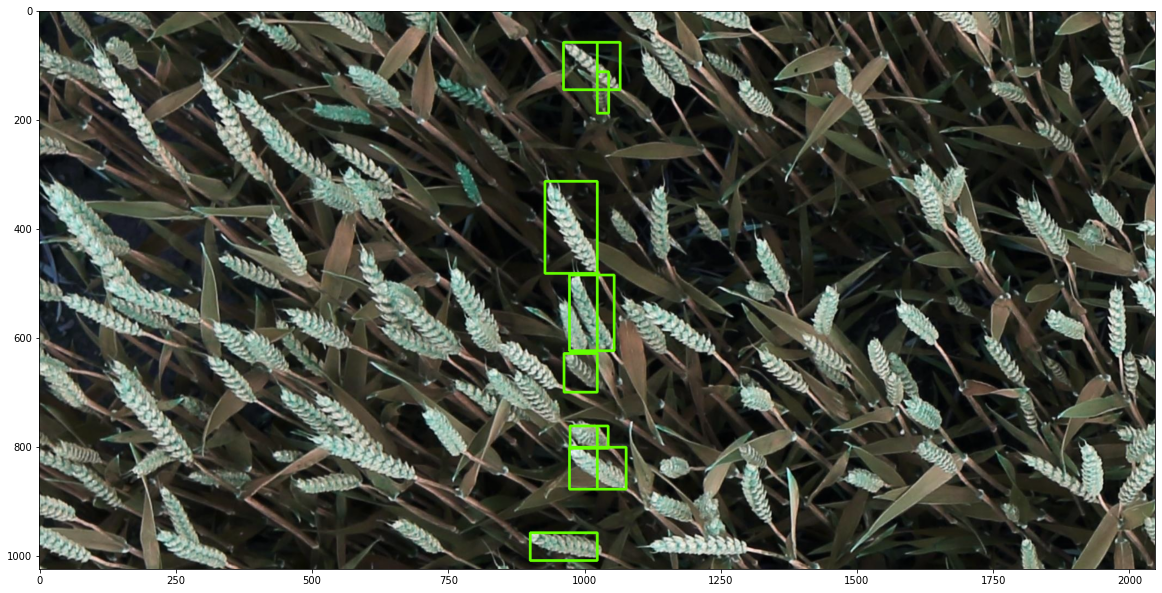

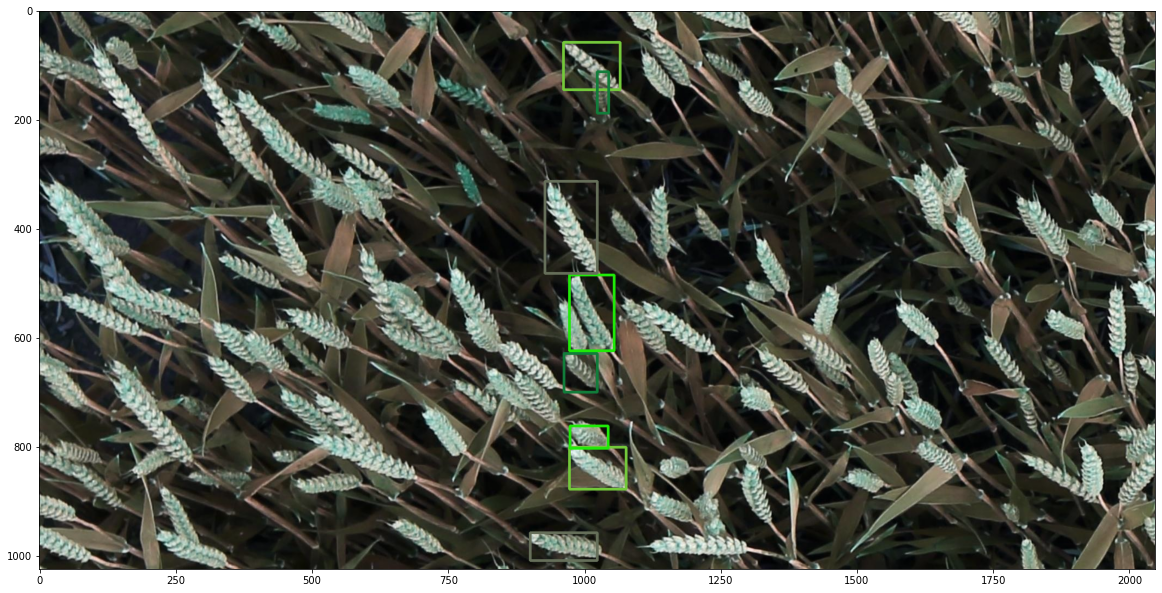

In [105]:
color = list(np.random.choice(range(256), size=100))

idx = 35

imid = csvs[idx].image_id.values[0]
size = 20
fig, ax = plt.subplots(1, 1, figsize=(size, size))
DIR_TEST = '/home/peiyuanl/kaggle/wheat_det/origin_img'
img_pth = os.path.join(DIR_TEST, imid+'.jpg')
print(img_pth)
image = cv2.imread(img_pth)

#boxes = [mat[41], mat[60]]
#boxes = mat[x1_cands]
boxes = cands.loc[cands['image_id']==imid][['x1','y1','x2','y2']].values
#boxes = [mat[0], mat[2]]
#np.random.shuffle(boxes)
#print(boxes.shape)
i = 0
for box in boxes:
    print(box)
    image = cv2.rectangle(image,(box[0], box[1]),(box[2], box[3]),(102,255,0), 3)
    i+=1

ax.imshow(image)

print('--------')

fig2, ax2 = plt.subplots(1, 1, figsize=(size, size))
image2 = cv2.imread(img_pth)

boxes = csvs[idx][['x1','y1','x2','y2']].values
#boxes = [mat[0], mat[2]]
#np.random.shuffle(boxes)
#print(boxes.shape)
i = 0
k = 0
for box in boxes:
    print(box)
    if i % 2 == 0:
        colors = (int(color[k]), int(color[k+1]), int(color[k+2]))
        k+=3
    image2 = cv2.rectangle(image2,(box[0], box[1]),(box[2], box[3]),colors, 3)
    i+=1

ax2.imshow(image2)

/home/peiyuanl/kaggle/wheat_det/origin_img/ethz_1_8f65fc2b9_4bb9bab8b.jpg
--------


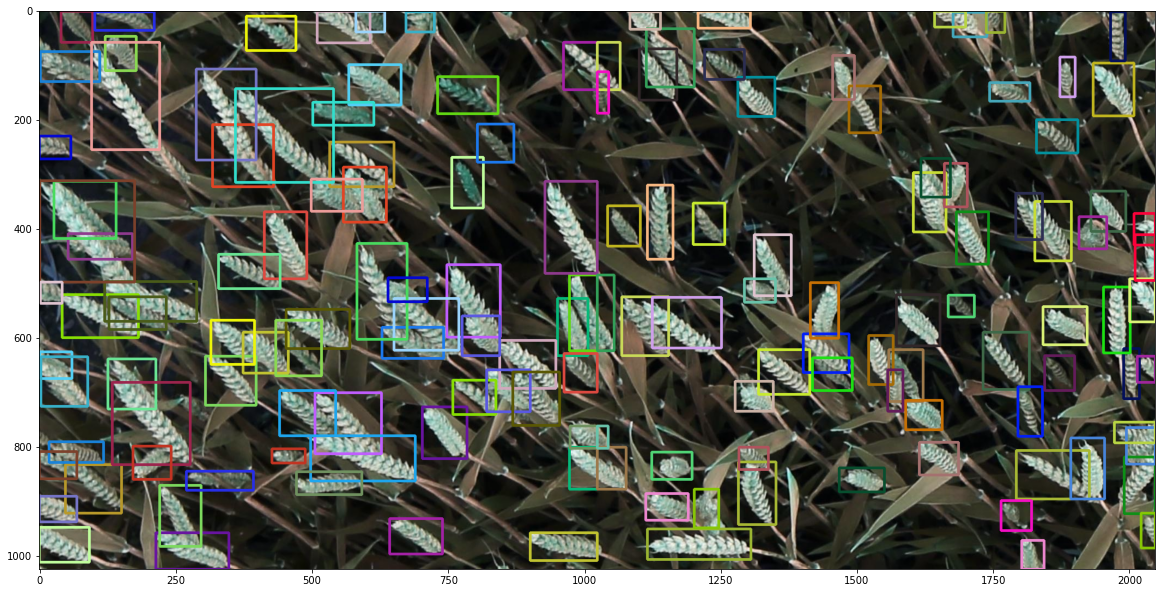

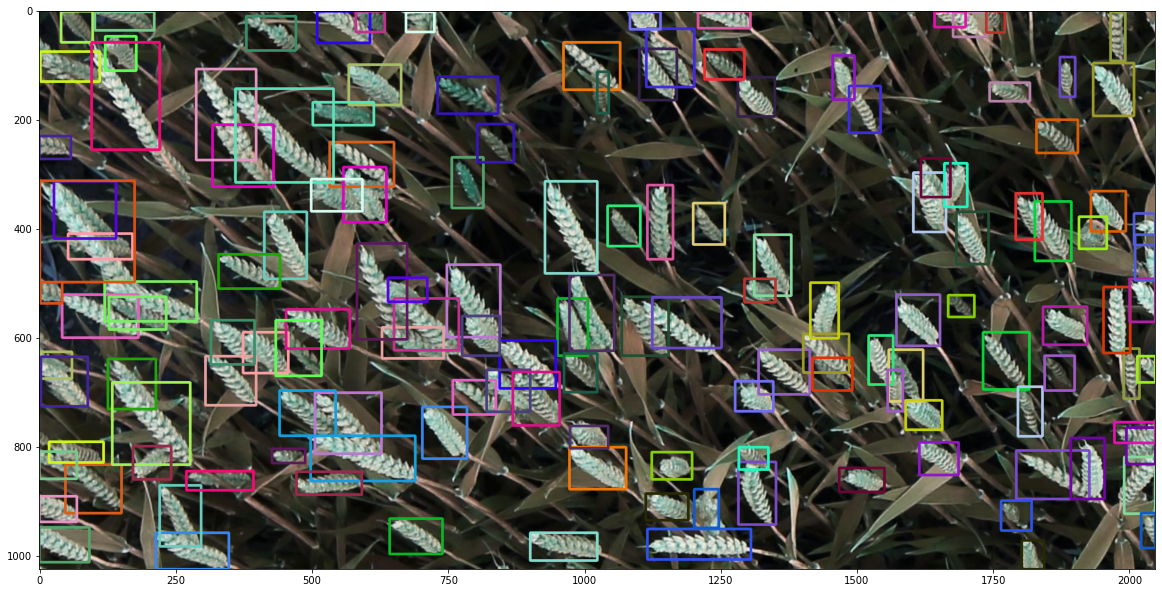

In [113]:
color = list(np.random.choice(range(256), size=300))

idx = 35

imid = csvs[idx].image_id.values[0]
size = 20
fig, ax = plt.subplots(1, 1, figsize=(size, size))
DIR_TEST = '/home/peiyuanl/kaggle/wheat_det/origin_img'
img_pth = os.path.join(DIR_TEST, imid+'.jpg')
print(img_pth)
image = cv2.imread(img_pth)

#boxes = [mat[41], mat[60]]
#boxes = mat[x1_cands]
boxes = df.loc[df['image_id']==imid][['x1','y1','x2','y2']].values
#boxes = [mat[0], mat[2]]
#np.random.shuffle(boxes)
#print(boxes.shape)
i = 0
for box in boxes:
    #print(box)
    if i % 2 == 0:
        k%=295
        colors = (int(color[k]), int(color[k+1]), int(color[k+2]))
        k+=3
    image = cv2.rectangle(image,(box[0], box[1]),(box[2], box[3]),colors, 3)
    i+=1

ax.imshow(image)

print('--------')

fig2, ax2 = plt.subplots(1, 1, figsize=(size, size))
image2 = cv2.imread(img_pth)

boxes = corrected.loc[corrected['image_id']==imid][['x1','y1','x2','y2']].values
#boxes = [mat[0], mat[2]]
#np.random.shuffle(boxes)
#print(boxes.shape)
i = 0
k = 0
for box in boxes:
    #print(box)
    if i % 2 == 0:
        k%=295
        colors = (int(color[k]), int(color[k+1]), int(color[k+2]))
        k+=3
    image2 = cv2.rectangle(image2,(box[0], box[1]),(box[2], box[3]),colors, 3)
    i+=1

ax2.imshow(image2)

In [ ]:
b =pd.concat([df,df])

In [ ]:
b.drop_duplicates() == df

In [ ]:
set([1,2,3]) - set([1])

In [ ]:
import numpy as np
import os
from PIL import Image
from tqdm import tqdm
import json